# Introduction

매일 Kaggle의 예제들을 공부하고 하면서 언젠간 나도 Titanic 예제에 대해 분석하고 싶었고, 이번에 이유한님 커리큘럼에 있는 타이타닉 공부를 끝마치면서 다른 자료들을 참고하면서 해보았다.  
전체적으로 2번째에 작성한 Titanic Top 4% with Ensemble Modeling 노트북을 많이 참고하였고, EDA to Prediction(DieTanic)도 참고하였다. 확실히 직접해보면서 아직도 데이터프레임을 다루는 것이 익숙하지 않고, 특히 시각화 툴에 대한 공부를 좀 더 해야한다고 느꼈다.  

타이타닉은 1912년 3월 15일 빙산과 충돌한 다시는 일어나선 안될 선박 사고로, 2,224명의 승객, 승무원 중 1502명이 사망한 사건이다.  

Titanic 데이터는 아래와 같이 구성되어 있다.
- PassengerId: 탑승자 데이터 일련번호
- Survived: 생존여부, 0 = 사망, 1 = 생존
- Pclass: 티켓의 선실 등급, 1 = 일등석, 2 = 이등석, 3 = 삼등석
- Sex: 탑승자 성별
- Name: 탑승자 이름
- Age: 탑승자 나이
- SibSp: 같이 탑승한 형제, 자매 또는 배우자 인원 수
- Parch: 같이 탑승한 부모님 또는 자녀 인원 수
- Ticket: 티켓 번호
- Fare: 요금
- Cabin: 선실 번호
- Embarked: 탑승 항구, C = Cherbourg, Q = Queenstown, S = Southampton

## Load Data

In [2]:
import pandas as pd # 0.25.1
import numpy as np # 1.18.5
import matplotlib.pyplot as plt # 3.2.2
import seaborn as sns # 0.10.1

import warnings
warnings.filterwarnings('ignore')

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
PassengerId = test['PassengerId']
train_len = len(train)

train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [4]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

train의 Null 값: Age(177), Cabin(687), Embarked(2)

In [5]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

test의 Null 값: Age(86), Fare(1), Cabin(327)

In [6]:
train.shape, test.shape

((891, 12), (418, 11))

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## Numerical values correlation

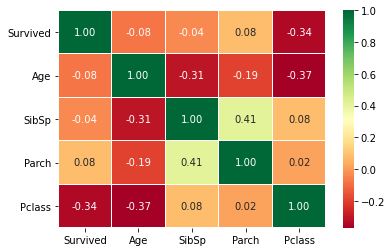

In [8]:
sns.heatmap(train[['Survived', 'Age', 'SibSp', 'Parch', 'Pclass']].corr(), annot=True, fmt='.2f', cmap='RdYlGn', linewidths=0.2, annot_kws={'size': 10})

- Survived와 Pclass 간에 음의 상관관계가 있고 이는 Pclass가 1등급에 가까울수록 생존률이 높음을 의미한다.
- Age와 SibSp, Pclass 간에 음의 상관관계가 있고 이는 나이가 많아질수록 SibSp의 수는 줄고, Pclass가 1등급에 가까워짐을 의미한다.
- SibSp와 Parch 간에 양의 상관관계가 있고 이는 SibSp가 증가할수록 Parch의 수도 증가함을 의미한다.

## Joining train and test data

In [9]:
data = pd.concat([train, test], axis=0).reset_index(drop=True)

In [10]:
data = data.fillna(np.nan)
data.isnull().sum()

Age             263
Cabin          1014
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

# Feature Analysis
## Categorical Values
변수들의 가장 기본적인 특징으로 먼저 분류해보았다. 밑에서 언급할 **Sex, Pclass, Embarked** 는 명목형 변수이다. 
### Sex

나는 타이타닉 영화를 보지않았지만, 타이타닉 분석 노트북들을 보면 대부분 하는 얘기는 **"여성과 아이 먼저"** 였다. 먼저 성별에 대한 생존률에 대해 알아보자.

In [11]:
pd.crosstab(train.Sex, train.Survived, margins=True)

Survived,0,1,All
Sex,,,
female,81,233,314
male,468,109,577
All,549,342,891


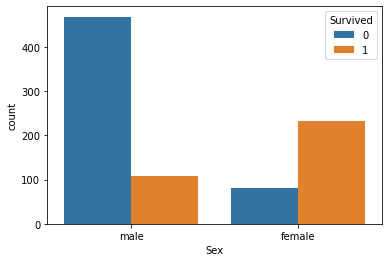

In [12]:
sns.countplot(train['Sex'], hue=train['Survived'])

In [13]:
print('여성의 비율: ', train['Sex'][train['Sex']=='female'].count() / train['Sex'].count())
print('남성의 비율: ', train['Sex'][train['Sex']=='male'].count() / train['Sex'].count())
print('여성의 생존률: ', train['Sex'][(train['Sex']=='female') & (train['Survived']==1)].count() / train['Sex'][train['Sex']=='female'].count())
print('남성의 생존률: ', train['Sex'][(train['Sex']=='male') & (train['Survived']==1)].count() / train['Sex'][train['Sex']=='male'].count())

여성의 비율:  0.35241301907968575
남성의 비율:  0.6475869809203143
여성의 생존률:  0.7420382165605095
남성의 생존률:  0.18890814558058924


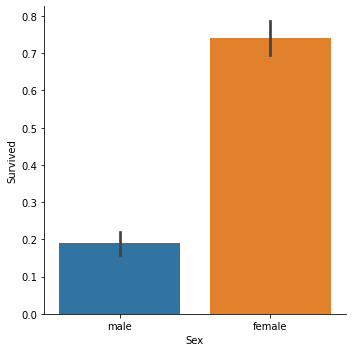

In [14]:
sns.factorplot('Sex', 'Survived', data=train, kind='bar')

확실히 탑승자 중 남성의 비율(64.8%)이 여성(35.2%)보다 높은데 여성의 생존률(74.2%)이 남성의 생존률(18.9%)보다 높다.

### Pclass
공부하면서, 직접 생각해보면서 좋은 등급의 승객일수록 생존률이 높을것이라고 생각했다. 이번엔 Pclass당 생존률에 대해 알아보자.

In [15]:
train['Pclass'].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

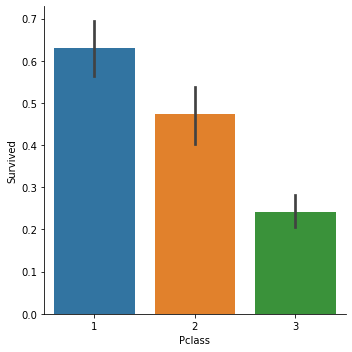

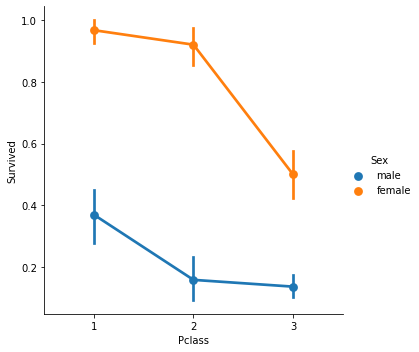

In [16]:
g = sns.factorplot('Pclass', 'Survived', data=train, kind='bar')
g.set_titles('Pclass vs Survived')
g = sns.factorplot('Pclass', 'Survived', data=train, hue='Sex')
g.set_titles('Sex: Pclass vs Survived')

1등급 승객의 생존률이 높고, 등급에 상관없이 여성의 생존률이 높지만 3등급에서의 여성의 생존률은 확연하게 1, 2등급에 비해 떨어지는 것을 알 수 있다.(돈이 최고...)

### Embarked
어떤 항구에서 탑승했는지가 생존률에 미치는 영향을 알아보자.

In [17]:
train['Embarked'].value_counts(dropna=False)

S      644
C      168
Q       77
NaN      2
Name: Embarked, dtype: int64

In [18]:
# S에서 탑승한 승객 수가 많으므로 S로 채움
train['Embarked'] = train['Embarked'].fillna('S')

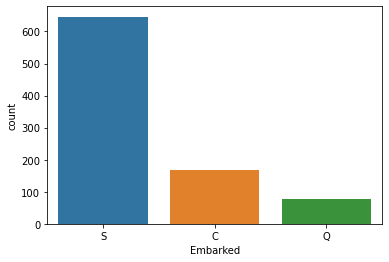

In [19]:
sns.countplot(train['Embarked'])

Text(0.5, 1.0, 'Sex: Embarked vs Survived')

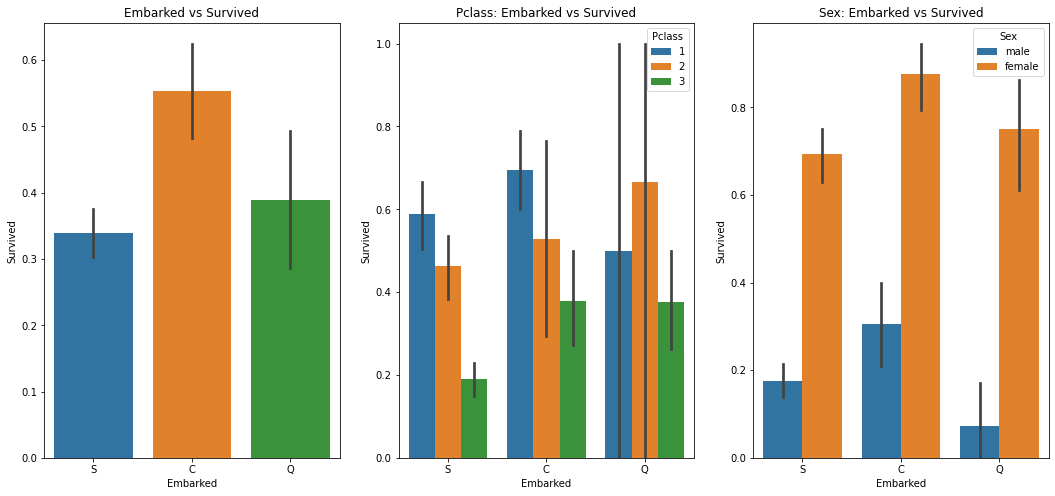

In [20]:
f, ax = plt.subplots(1, 3, figsize=(18, 8))
sns.barplot('Embarked', 'Survived', data=train, ax=ax[0])
ax[0].set_title('Embarked vs Survived')
sns.barplot('Embarked', 'Survived', hue='Pclass', data=train, ax=ax[1])
ax[1].set_title('Pclass: Embarked vs Survived')
sns.barplot('Embarked', 'Survived', hue='Sex', data=train, ax=ax[2])
ax[2].set_title('Sex: Embarked vs Survived')

1. S항구의 탑승한 승객의 수가 월등히 많은데, C에서 탑승한 승객의 생존률이 높게 나타났다.
2. 일반적으로 1등급 승객의 생존률이 높은데, Q항구에서 탑승한 승객의 경우에는 2등급 승객의 생존률이 높다.
3. 어떤 항구에서 탑승하던 여성의 생존률이 높다.

어쩌면 2번째 그림에서 나타난 2등급 승객의 생존률이 높은 것은 2등급에 탑승한 여성의 수가 많아서 일수도있다.

In [21]:
pd.crosstab([train.Embarked, train.Pclass], train.Sex, margins=True).style.background_gradient(cmap='spring')

Q에서 1등급, 2등급 승객의 생존률이 각각 0.5, 0.66 이 나온 이유는 탑승자 수가 2명, 3명밖에 안되서임을 알 수 있다.

## Numerical Values
이번엔 연속/이산형 변수들에 대해 알아보자. **SibSp, Parch, Fare** 가 그 예이다.
### SibSp

In [22]:
train['SibSp'].value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

In [23]:
train[train['SibSp']==8]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


타이타닉에 대해 분석한 다른 사람들의 예제를 보면서 SibSp가 8인 값이 어쩌면 결측치일수도 있을것이라고 생각했었다.  
[Titanic Top 4% with ensemble modeling](https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling) 에서 이상치 분석을 통해 PassengerId가 (28, 89, 160, 181, 202, 325, 342, 793, 847, 864) 인 승객들을 드롭했었다. SibSp가 8인 승객들이 Age, Cabin이 다 NaN이고 Name, Sex를 제외한 모든 값이 같다. 이상치로 판단해 이 데이터들을 드롭하는게 나을 것 같다.

In [24]:
train = train.drop(train[train['SibSp']==8].index, axis=0).reset_index(drop=True)

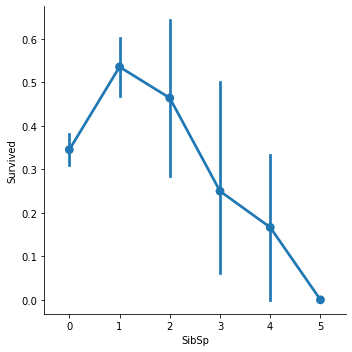

In [25]:
sns.factorplot('SibSp', 'Survived', data=train)

SibSp가 1또는 2인 경우가 생존률이 높고 많아질수록 생존률이 낮아진다.

### Parch

In [26]:
train['Parch'].value_counts()

0    678
1    118
2     73
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

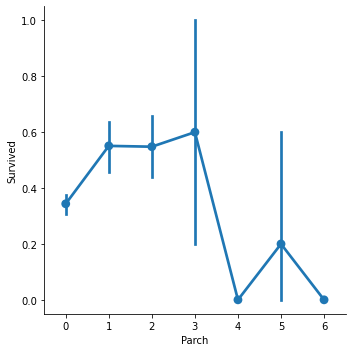

In [27]:
sns.factorplot('Parch', 'Survived', data=train)

여기서도 SibSp와 유사하게 1, 2, 3명인 경우의 생존률이 높고 4, 5, 6처럼 대가족이 되면 생존률이 낮아진다.

### Fare

In [28]:
data['Fare'] = data['Fare'].fillna(data['Fare'].median())

In [29]:
print(f'가장 높은 요금 : {data.Fare.max()}')
print(f'가장 낮은 요금 : {data.Fare.min()}')
print(f'요금의 평균: {data.Fare.mean()}')

가장 높은 요금 : 512.3292
가장 낮은 요금 : 0.0
요금의 평균: 33.28108563789156


무료로 탑승한 승객들도 있다. (무료로 탔는데 사고가 나서 억울할거같다..)

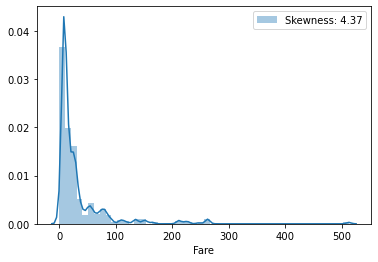

In [30]:
g = sns.distplot(data['Fare'], label='Skewness: %.2f'%(data['Fare'].skew()))
g.legend(loc='best')

요금은 당연히 Pclass에 따라 다를 것이고, 이렇게 큰 차이를 가지는 값은 ML 모델 형성에 좋지 않은 영향을 미칠 수 있다. Fare 전체에 *log* 를 취해 비대칭도(Skewness)를 낮추는 것이 좋아보인다.

In [31]:
data['Fare'] = data['Fare'].map(lambda x: np.log(x) if x > 0 else 0)

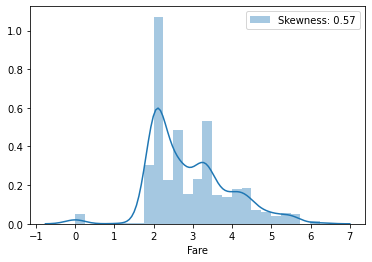

In [32]:
g = sns.distplot(data['Fare'], label='Skewness: %.2f'%(data['Fare'].skew()))
g.legend(loc='best')

## Filling NaN(Age)
아까 위에서 봤을 때 Age는 train, test를 합쳐 263개의 Null 값이 존재했다. Age가 어떠한 피쳐들과 연관이 있는지 먼저 알아보자.

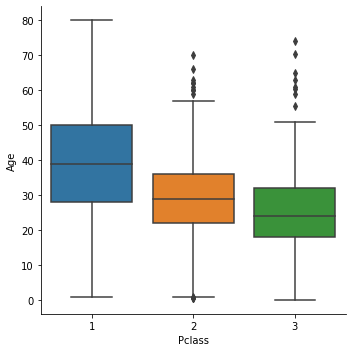

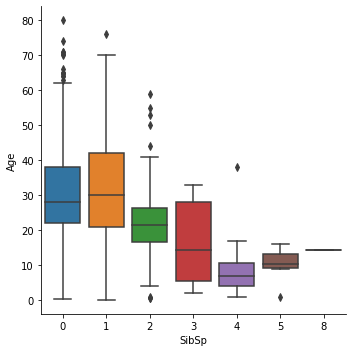

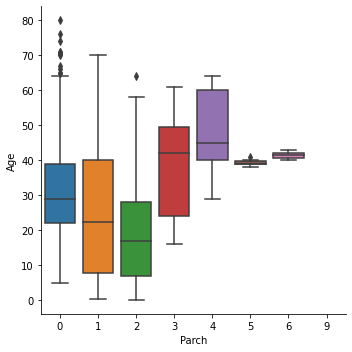

In [33]:
sns.factorplot('Pclass', 'Age', data=data, kind='box')
sns.factorplot('SibSp', 'Age', data=data, kind='box')
sns.factorplot('Parch', 'Age', data=data, kind='box')

1. Pclass가 높아짐(값이 작아짐)에 따라 나이가 증가한다.
2. SibSp가 증가함에 따라 나이가 어려지다가 5명 이상부터 다시 많아진다. 하지만 5, 6명일때의 데이터가 적어 확실하게 말할 순 없을 것 같다.
3. Parch가 증가함에 따라 나이가 어려지다가 3명 이상부터 다시 많아진다. 이도 5, 6, 9명일때의 데이터가 적어서 확실하게 말할 순 없을 것 같다.

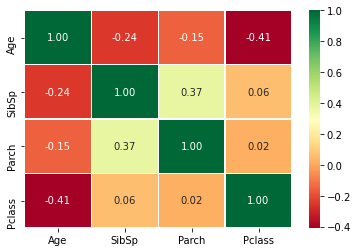

In [34]:
sns.heatmap(data[['Age', 'SibSp', 'Parch', 'Pclass']].corr(), annot=True, fmt='.2f', cmap='RdYlGn', linewidths=0.2, annot_kws={'size': 10})

위에 그래프에서 봤던 것 처럼 **SibSp, Parch, Pclass** 는 **Age** 와 음의 상관관계를 갖는다. 이 중 상관계수가 높은 *SibSp, Pclass* 를 이용해 Age의 결측값을 채워도록 하겠다.  
그리고 SibSp와 Parch의 상관계수가 높게나와 아래에 FamilySize로 결합시키려한다.

In [35]:
index_NaN_age = list(data['Age'][data['Age'].isnull()].index)

for i in index_NaN_age:
    age_med = data['Age'].median()
    age_pred = data['Age'][((data['SibSp'] == data.iloc[i]['SibSp']) & (data['Pclass'] == data.iloc[i]['Pclass']))].median()
    if np.isnan(age_pred):
        data['Age'].iloc[i] = age_med
    else:
        data['Age'].iloc[i] = age_pred

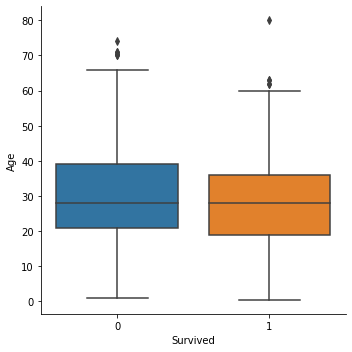

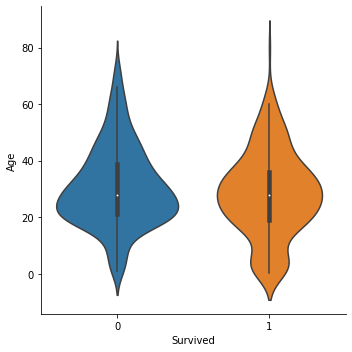

In [36]:
sns.factorplot('Survived', 'Age', data=train, kind='box')
sns.factorplot('Survived', 'Age', data=train, kind='violin')

생존여부에 따른 나이의 중간값은 큰 차이는 없는 것 같다. 하지만 0-5세 정도의 나이에서 생존률이 높은 것을 알 수 있다.

# Feature Engineering
## Name/Title
이름은 그냥 보기엔 큰 정보가 없는 것 같지만 영어 이름이다보니 Mr, Mrs 등이 포함되어 이 정보를 추출해 볼 수 있다.

In [37]:
data['Name'].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [38]:
data_title = [i.split(',')[1].split('.')[0].strip() for i in data['Name']]
data['Title'] = pd.Series(data_title)
data['Title'].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

In [39]:
pd.crosstab(data['Title'], data['Sex']).T

Title,Capt,Col,Don,Dona,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir,the Countess
Sex,,,,,,,,,,,,,,,,,,
female,0,0,0,1,1,0,1,0,0,260,2,1,0,197,2,0,0,1
male,1,4,1,0,7,1,0,2,61,0,0,0,757,0,0,8,1,0


In [40]:
data.groupby('Title')['Age'].mean()

Title
Capt            70.000000
Col             54.000000
Don             40.000000
Dona            39.000000
Dr              42.875000
Jonkheer        38.000000
Lady            48.000000
Major           48.500000
Master           7.509508
Miss            22.048423
Mlle            24.000000
Mme             24.000000
Mr              31.009247
Mrs             36.025381
Ms              26.500000
Rev             41.250000
Sir             49.000000
the Countess    33.000000
Name: Age, dtype: float64

생각보다 많은 Title이 존재하는데 이 중 여성만 있는 Title도 있고 남성만 있는 Title도 있다. 이를 먼저 정리하자.

In [41]:
data['Title'] = data['Title'].replace(['Capt', 'Col', 'Don', 'Jonkheer', 'Major', 'Rev', 'Sir'], 'Mr')
data['Title'] = data['Title'].replace(['Dona', 'Lady', 'the Countess'], 'Mrs')
data['Title'] = data['Title'].replace(['Mlle', 'Mme', 'Ms'], 'Miss')

In [42]:
data.groupby('Title')['Age'].mean()

Title
Dr        42.875000
Master     7.509508
Miss      22.104113
Mr        31.372903
Mrs       36.085000
Name: Age, dtype: float64

사실 Master는 처음 들어보는데 남자 아이들이 많은 것 같다. 이 부분은 일단 손대지 않고 1명의 여성관 7명의 남성이 있는 Dr를 나누자.

In [43]:
data[data['Title']=='Dr'].index

Int64Index([245, 317, 398, 632, 660, 766, 796, 1184], dtype='int64')

In [44]:
for i in data[data['Title']=='Dr'].index:
    if data.loc[i]['Sex'] == 'male':
        data['Title'] = data['Title'].replace('Dr', 'Mr')
    else:
        data['Title'] = data['Title'].replace('Dr', 'Mrs')

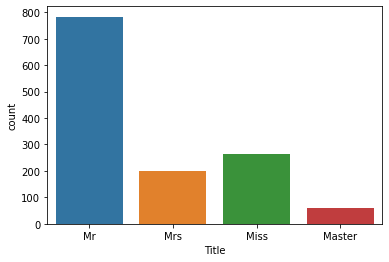

In [45]:
g = sns.countplot(data['Title'])

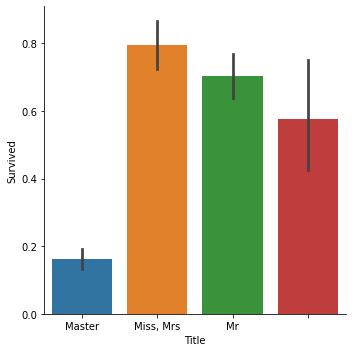

In [46]:
g = sns.factorplot('Title', 'Survived', data=data, kind='bar')
g.set_xticklabels(['Master', 'Miss, Mrs', 'Mr'])

Title이 str형이므로 더미를 생성해서 one-hot encoding을 한다.

In [47]:
data = pd.get_dummies(data, columns=['Title'], prefix='Title')
data.drop(labels=['Name'], axis=1, inplace=True)

## FamilySize
SibSp와 Parch 는 위에서 언급했듯이 상관계수가 조금 높은 편이였다. 이 둘을 합치고 1(자기 자신)을 더해 FamilySize 칼럼을 만들자.

In [48]:
data['F_size'] = data['SibSp'] + data['Parch'] + 1

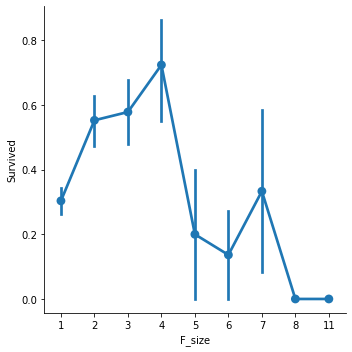

In [49]:
sns.factorplot('F_size', 'Survived', data=data)

위 그래프를 총 4개 정도로 나눌 수 있을 것 같다. (1 / 2-4 / 5-7 / 7이상)

In [50]:
data['Single'] = data['F_size'].map(lambda s: 1 if s == 1 else 0)
data['SmallF'] = data['F_size'].map(lambda s: 1 if 2 <= s <= 4 else 0)
data['MedF'] = data['F_size'].map(lambda s: 1 if 5 <= s <= 7 else 0)
data['LargeF'] = data['F_size'].map(lambda s: 1 if s >= 8 else 0)
data.drop(labels=['F_size'], axis=1, inplace=True)
data.head(3)

,Age,Cabin,Embarked,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Single,SmallF,MedF,LargeF
0,22.0,NaN,S,1.981001,0,1,3,male,1,0.0,A/5 21171,0,0,1,0,0,1,0,0
1,38.0,C85,C,4.266662,0,2,1,female,1,1.0,PC 17599,0,0,0,1,0,1,0,0
2,26.0,NaN,S,2.070022,0,3,3,female,0,1.0,STON/O2. 3101282,0,1,0,0,1,0,0,0


## Fare_cat
연속형 변수인 요금도 카테고리화 하도록 하자. 사분위수를 이용해 분류하도록 하자.

In [51]:
data['Fare_1'] = data['Fare'].map(lambda f: 1 if f <= np.percentile(data['Fare'], 25) else 0)
data['Fare_2'] = data['Fare'].map(lambda f: 1 if np.percentile(data['Fare'], 25) < f <= np.percentile(data['Fare'], 50) else 0)
data['Fare_3'] = data['Fare'].map(lambda f: 1 if np.percentile(data['Fare'], 50) < f <= np.percentile(data['Fare'], 75) else 0)
data['Fare_4'] = data['Fare'].map(lambda f: 1 if f > np.percentile(data['Fare'], 75) else 0)
data.drop(labels=['Fare'], axis=1, inplace=True)

## Cabin
노트북들을 보면 Cabin을 이용하는 경우도 있고 제거하는 경우도 있었다. NaN이 1014개나 나오고 Null 값 비중이 너무 커서 삭제하도록 하겠다.

In [52]:
data['Cabin'].value_counts(dropna=False)

NaN                1014
C23 C25 C27           6
B57 B59 B63 B66       5
G6                    5
C22 C26               4
                   ... 
B82 B84               1
A6                    1
D45                   1
A29                   1
A10                   1
Name: Cabin, Length: 187, dtype: int64

In [53]:
data.drop(labels=['Cabin'], axis=1, inplace=True)

In [54]:
data.head(3)

,Age,Embarked,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title_Master,...,Title_Mr,Title_Mrs,Single,SmallF,MedF,LargeF,Fare_1,Fare_2,Fare_3,Fare_4
0,22.0,S,0,1,3,male,1,0.0,A/5 21171,0,...,1,0,0,1,0,0,1,0,0,0
1,38.0,C,0,2,1,female,1,1.0,PC 17599,0,...,0,1,0,1,0,0,0,0,0,1
2,26.0,S,0,3,3,female,0,1.0,STON/O2. 3101282,0,...,0,0,1,0,0,0,0,1,0,0


## Ticket

In [55]:
data['Ticket'].value_counts()

CA. 2343           11
CA 2144             8
1601                8
347077              7
3101295             7
                   ..
349239              1
STON/OQ. 369943     1
347466              1
373450              1
345501              1
Name: Ticket, Length: 929, dtype: int64

In [56]:
data['Ticket'].head(10)

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
5              330877
6               17463
7              349909
8              347742
9              237736
Name: Ticket, dtype: object

Ticket도 사실 어느정도 쓸모있는지 모르겠어서 삭제하겠다.

In [57]:
data.drop(labels=['Ticket'], axis=1, inplace=True)

## Age_cat
나이도 연속형 변수로 최솟값이 0, 최댓값이 80이였다. 이를 4등분해서 one-hot encoding을 하자.

In [58]:
data['Age_1'] = data['Age'].map(lambda a: 1 if a <= 20 else 0)
data['Age_2'] = data['Age'].map(lambda a: 1 if 20 < a <= 40 else 0)
data['Age_3'] = data['Age'].map(lambda a: 1 if 40 < a <= 60 else 0)
data['Age_4'] = data['Age'].map(lambda a: 1 if a > 60 else 0)

In [60]:
data.drop(labels=['Age'], axis=1, inplace=True)

## Other Values

In [61]:
data.head()

,Embarked,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Title_Master,Title_Miss,Title_Mr,...,MedF,LargeF,Fare_1,Fare_2,Fare_3,Fare_4,Age_1,Age_2,Age_3,Age_4
0,S,0,1,3,male,1,0.0,0,0,1,...,0,0,1,0,0,0,0,1,0,0
1,C,0,2,1,female,1,1.0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
2,S,0,3,3,female,0,1.0,0,1,0,...,0,0,0,1,0,0,0,1,0,0
3,S,0,4,1,female,1,1.0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
4,S,0,5,3,male,0,0.0,0,0,1,...,0,0,0,1,0,0,0,1,0,0


위에서 처리하지 않고 온 변수들이 있기에 모두 처리해주자

In [62]:
data = pd.get_dummies(data, columns=['Embarked'], prefix='Em')
data['Sex'] = data['Sex'].map({'female': 0, 'male': 1})
data['Pclass'] = data['Pclass'].astype('category')
data = pd.get_dummies(data, columns=['Pclass'], prefix='Pc')
data.drop(labels=['Parch', 'PassengerId', 'SibSp'], axis=1, inplace=True)

In [63]:
data.columns

Index(['Sex', 'Survived', 'Title_Master', 'Title_Miss', 'Title_Mr',
       'Title_Mrs', 'Single', 'SmallF', 'MedF', 'LargeF', 'Fare_1', 'Fare_2',
       'Fare_3', 'Fare_4', 'Age_1', 'Age_2', 'Age_3', 'Age_4', 'Em_C', 'Em_Q',
       'Em_S', 'Pc_1', 'Pc_2', 'Pc_3'],
      dtype='object')

# Modeling

In [64]:
train = data[:train_len]
test = data[train_len:]
test.drop(labels=['Survived'], axis=1, inplace=True)

In [65]:
train['Survived'] = train['Survived'].astype(int)
y_train = train['Survived']
x_train = train.drop(labels=['Survived'], axis=1)

## Classifiers
유명한 10가지 분류기를 사용하려한다.  

1. SVC
2. Decision Tree
3. AdaBoost
4. Random Forest
5. Extra Trees
6. Gradient Boosting
7. Multiple layer perceptron(neural network)
8. KNN
9. Logistic Regression
10. Linear Discriminant Analysis

In [66]:
# scikit-learn 0.23.1
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

[0.8305493133583021, 0.812621722846442, 0.8126092384519351, 0.811498127340824, 0.8148689138576779, 0.8316978776529339, 0.8182272159800249, 0.8171785268414482, 0.8271785268414481, 0.8282771535580524]


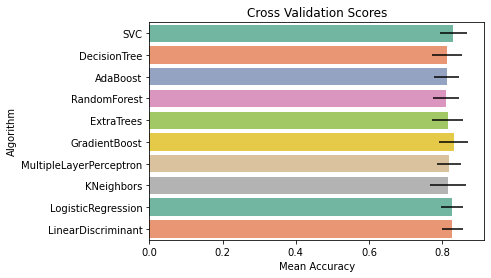

In [67]:
kfold = StratifiedKFold(n_splits=10)
random_state = 2021
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state), random_state=random_state, learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state=random_state))
classifiers.append(LinearDiscriminantAnalysis())

cvs_results = []
for classifier in classifiers:
    cvs_results.append(cross_val_score(classifier, x_train, y=y_train, scoring='accuracy', cv=kfold, n_jobs=-1))

cvs_means = []
cvs_std = []
for cvs_result in cvs_results:
    cvs_means.append(cvs_result.mean())
    cvs_std.append(cvs_result.std())

cvs_re = pd.DataFrame({'CrossValMeans': cvs_means, 'CrossValStd': cvs_std, 'Algorithm': ['SVC', 'DecisionTree',
                                                                                        'AdaBoost', 'RandomForest',
                                                                                        'ExtraTrees', 'GradientBoost',
                                                                                        'MultipleLayerPerceptron', 'KNeighbors',
                                                                                        'LogisticRegression', 'LinearDiscriminant']})

g = sns.barplot('CrossValMeans', 'Algorithm', data=cvs_re, palette='Set2', orient='h', **{'xerr': cvs_std})
g.set_xlabel('Mean Accuracy')
g.set_title('Cross Validation Scores')
print(cvs_means)

## Hyperparameter Tunning

In [68]:
# SVC(50.6s)
SVMC = SVC(probability=True)
svc_params = {'kernel': ['rbf', 'linear'],
             'gamma': [0.001, 0.01, 0.1, 1, 10],
             'C': [1, 10, 50, 100, 200, 300, 500, 1000]}
gsSVM = GridSearchCV(SVMC, param_grid=svc_params, cv=kfold, scoring='accuracy', n_jobs=-1, verbose=1)
gsSVM.fit(x_train, y_train)
gsSVM_best = gsSVM.best_estimator_
gsSVM.best_score_

Fitting 10 folds for each of 80 candidates, totalling 800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 658 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:   50.5s finished


0.8316479400749064

In [69]:
# AdaBoost(2.89s)
DTC = DecisionTreeClassifier()
adaDTC = AdaBoostClassifier(DTC, random_state=random_state)
ada_params = {'base_estimator__criterion': ['gini', 'entropy'],
             'base_estimator__splitter': ['best', 'random'],
             'algorithm': ['SAMME', 'SAMME.R'],
             'n_estimators': [1, 2],
             'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 1.0, 1.5]}
gsadaDTC = GridSearchCV(adaDTC, param_grid=ada_params, cv=kfold, n_jobs=-1, verbose=1)
gsadaDTC.fit(x_train, y_train)
gsadaDTC_best = gsadaDTC.best_estimator_
gsadaDTC.best_score_

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 10 folds for each of 128 candidates, totalling 1280 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1280 out of 1280 | elapsed:    2.9s finished


0.817103620474407

In [70]:
# RandomForest(3m 21s)
RFC = RandomForestClassifier()
rf_params = {'max_depth': [None],
            'max_features': ['auto', 'sqrt', 'log2'],
            'min_samples_split': [2, 3, 10],
            'min_samples_leaf': [1, 3, 10],
            'n_estimators': [100, 300, 500],
            'criterion': ['gini', 'entropy']}
gsRFC = GridSearchCV(RFC, param_grid=rf_params, cv=kfold, n_jobs=-1, verbose=1, scoring='accuracy')
gsRFC.fit(x_train, y_train)
gsRFC_best = gsRFC.best_estimator_
gsRFC.best_score_

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 10 folds for each of 162 candidates, totalling 1620 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   50.6s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 1620 out of 1620 | elapsed:  3.4min finished


0.8350686641697876

In [71]:
# Extra Trees(2m 51s)
EXTC = ExtraTreesClassifier()
ex_params = {'max_depth': [None],
            'max_features': ['auto', 'sqrt', 'log2'],
            'min_samples_split': [2, 3, 10],
            'min_samples_leaf': [1, 3, 10],
            'n_estimators': [100, 300, 500],
            'criterion': ['gini', 'entropy']}
gsEXTC = GridSearchCV(EXTC, param_grid=ex_params, cv=kfold, scoring='accuracy', n_jobs=-1, verbose=1)
gsEXTC.fit(x_train, y_train)
gsEXTC_best = gsEXTC.best_estimator_
gsEXTC.best_score_

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 10 folds for each of 162 candidates, totalling 1620 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   44.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 1620 out of 1620 | elapsed:  2.8min finished


0.8373283395755304

In [72]:
# Gradient Boosting(1m 38s)
GBC = GradientBoostingClassifier()
gb_params = {'loss': ['deviance'],
            'n_estimators': [100, 300, 500],
            'learning_rate': [0.01, 0.05, 0.1],
            'max_depth': [4, 8, 12],
            'min_samples_leaf': [100, 150, 200],
            'max_features': [0.1, 0.2, 0.3]}
gsGBC = GridSearchCV(GBC, param_grid=gb_params, cv=kfold, scoring='accuracy', n_jobs=-1, verbose=1)
gsGBC.fit(x_train, y_train)
gsGBC_best = gsGBC.best_estimator_
gsGBC.best_score_

Fitting 10 folds for each of 243 candidates, totalling 2430 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 852 tasks      | elapsed:   34.6s
[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 2415 out of 2430 | elapsed:  1.6min remaining:    0.6s
[Parallel(n_jobs=-1)]: Done 2430 out of 2430 | elapsed:  1.6min finished


0.8316853932584269

In [73]:
# Multiple Perceptron(3m 18s)
MLP = MLPClassifier()
mlp_params = {'solver': ['lbfgs'],
              'max_iter': [1000, 1500, 2000],
              'alpha': 10.0 ** -np.arange(1, 5),
              'hidden_layer_sizes': np.arange(10, 15)}
gsMLP = GridSearchCV(MLP, param_grid=mlp_params, cv=kfold, scoring='accuracy', n_jobs=-1, verbose=1)
gsMLP.fit(x_train, y_train)
gsMLP_best = gsMLP.best_estimator_
gsMLP.best_score_

Fitting 10 folds for each of 60 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   45.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  2.1min finished


0.8260923845193509

In [74]:
# KNeibors(0.8s)
KNN = KNeighborsClassifier()
kn_params = {'n_neighbors': [3, 5, 7, 9, 11, 19],
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan']}
gsKNN = GridSearchCV(KNN, param_grid=kn_params, cv=kfold, scoring='accuracy', n_jobs=-1, verbose=1)
gsKNN.fit(x_train, y_train)
gsKNN_best = gsKNN.best_estimator_
gsKNN.best_score_

Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    0.9s finished


0.8204868913857677

In [75]:
# Logistic Regression(0.6s)
LR = LogisticRegression()
lr_params = {'C': np.logspace(-3, 3, 7),
            'penalty': ['l1', 'l2']}
gsLR = GridSearchCV(LR, param_grid=lr_params, cv=kfold, n_jobs=-1, scoring='accuracy', verbose=1)
gsLR.fit(x_train, y_train)
gsLR_best = gsLR.best_estimator_
gsLR.best_score_

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 10 folds for each of 14 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:    0.9s finished


0.8271785268414481

In [76]:
# Linear Discriminant(0.7s)
LD = LinearDiscriminantAnalysis()
ld_params = {'tol': np.logspace(-3, 3, 7),
            'solver': ['svd', 'lsqr', 'eigen']}
gsLD = GridSearchCV(LD, param_grid=ld_params, cv=kfold, n_jobs=-1, scoring='accuracy', verbose=1)
gsLD.fit(x_train, y_train)
gsLD_best = gsLD.best_estimator_
gsLD.best_score_

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 10 folds for each of 21 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    0.9s finished


0.8282771535580524

## Feature Importances

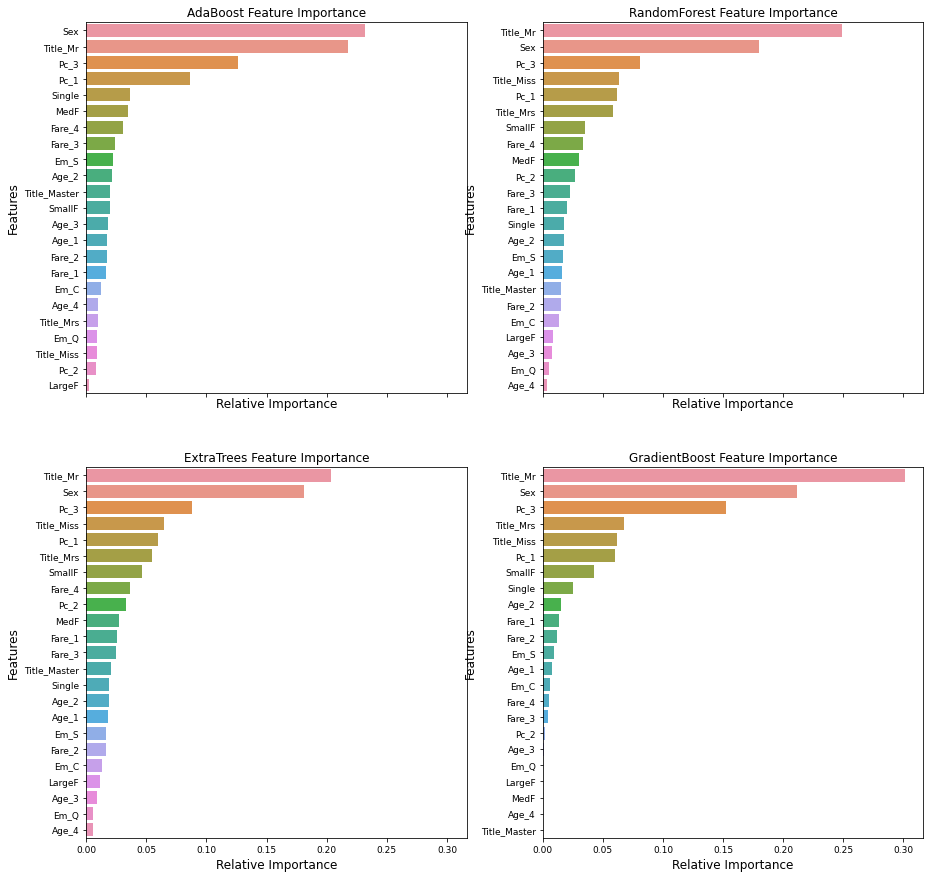

In [78]:
# 'SVC', MultipleLayerPerceptron, 'KNeighbors, 'LogisticRegression', 'LinearDiscriminant'는 feature importance 없음
nrows = ncols = 2
f, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex='all', figsize=(15, 15))
name_classifiers = [('AdaBoost', gsadaDTC_best), ('RandomForest', gsRFC_best), 
                    ('ExtraTrees', gsEXTC_best), ('GradientBoost', gsGBC_best)]
nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = name_classifiers[nclassifier][0]
        classifier = name_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        g = sns.barplot(x=classifier.feature_importances_[indices][:40], y=x_train.columns[indices][:40], orient='h', ax=ax[row][col])
        g.set_xlabel('Relative Importance', fontsize=12)
        g.set_ylabel('Features', fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + ' Feature Importance')
        nclassifier += 1

In [79]:
test_Survived_SVM = pd.Series(gsSVM_best.predict(test), name='SVM')
test_Survived_AdaD = pd.Series(gsadaDTC_best.predict(test), name='AdaD')
test_Survived_RFC = pd.Series(gsRFC_best.predict(test), name='RFC')
test_Survived_EXTC = pd.Series(gsEXTC_best.predict(test), name='EXTC')
test_Survived_GBC = pd.Series(gsGBC_best.predict(test), name='GBC')
test_Survived_MLP = pd.Series(gsMLP_best.predict(test), name='MLP')
test_Survived_KNN = pd.Series(gsKNN_best.predict(test), name='KNN')
test_Survived_LR = pd.Series(gsLR_best.predict(test), name='LR')
test_Survived_LD = pd.Series(gsLD_best.predict(test), name='LD')

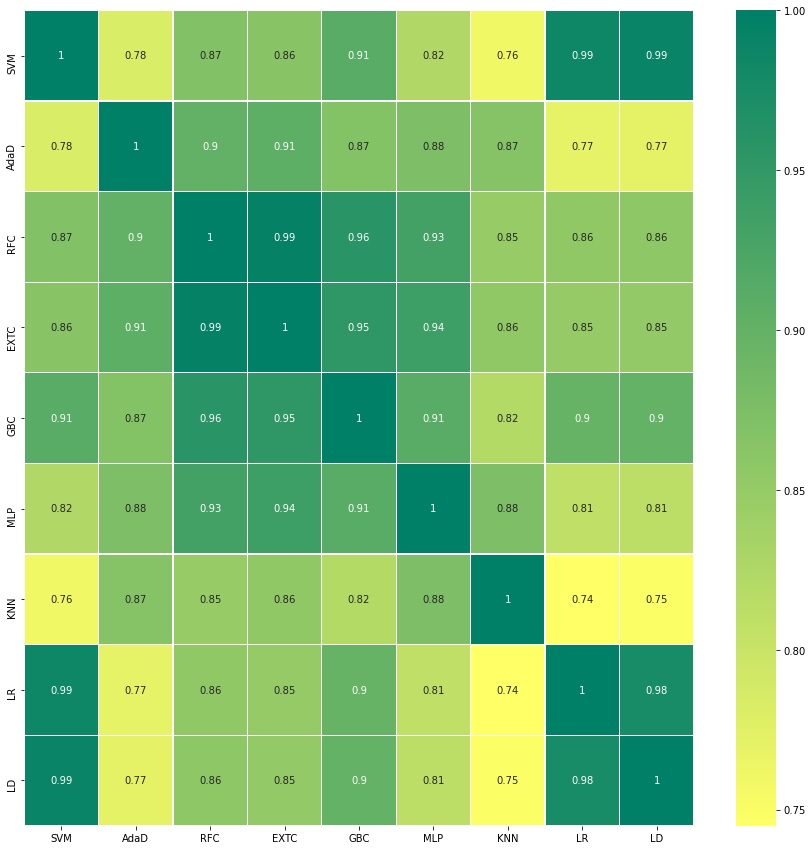

In [85]:
ensemble_results = pd.concat([test_Survived_SVM, test_Survived_AdaD, test_Survived_RFC, 
                              test_Survived_EXTC, test_Survived_GBC, test_Survived_MLP,
                              test_Survived_KNN, test_Survived_LR, test_Survived_LD], axis=1)
f, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(ensemble_results.corr(), annot=True, ax=ax, cmap='summer_r', linecolor='white', linewidths=0.3)

## Voting

분류기를 전부 다 넣고 할때 Public Score가 0.76794가 나오는데 5개(SVM, AdaBoost, RandomForest, ExtraTree, Gradient Boost)로 할 때 0.77990이 나왔다. 그래서 이 5개로 소프트 보팅을 진행한다.

In [86]:
votingC = VotingClassifier(estimators=[('svm', gsSVM_best), ('ada', gsadaDTC_best), ('rfc', gsRFC_best),
                                      ('extc', gsEXTC_best), ('gbc', gsGBC_best)], voting='soft', n_jobs=-1)
votingC.fit(x_train, y_train)

VotingClassifier(estimators=[('svm', SVC(C=1, gamma=0.1, probability=True)),
                             ('ada',
                              AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                                                       splitter='random'),
                                                 learning_rate=0.1,
                                                 n_estimators=2,
                                                 random_state=2021)),
                             ('rfc',
                              RandomForestClassifier(min_samples_leaf=3)),
                             ('extc',
                              ExtraTreesClassifier(criterion='entropy',
                                                   max_features='log2',
                                                   min_samples_leaf=3,
                                                   n_estimators=300)),
                             ('g

# Submission

In [87]:
test_Survived = pd.Series(votingC.predict(test), name='Survived')
results = pd.concat([PassengerId, test_Survived], axis=1)
results.to_csv('my_titanic_result.csv', index=False)